# CS182. Artificial Intelligence - Final Project

---

## Credit Card Fraud Classification/Amount Prediction

### Presented by Boyuan Sun, Yijun Shen, Shenghao Jiang

In [3]:
# import libraries
import json
import os
import sys
import time
from copy import deepcopy
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Before Constructing Models : Train-test split and defining predictors
The predictors will be Principle Components after PCA, which are preprocessed in the given dataset and Amount.
We have to be very careful with the train-test split: since the dataset is very imbalanced, we have to make sure that the train/test data set include enough amount of the observation that has a label of 1.

In [5]:
# Define predictors
predictors = list(data.columns)
predictors.remove('Class')
predictors.remove('Time')

In [6]:
# Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(data[predictors], data['Class'], test_size =.33, random_state = 182, stratify = data['Class'])

In [7]:
y_train = pd.DataFrame(y_train, columns = ['Class'])
y_test = pd.DataFrame(y_test, columns = ['Class'])

In [8]:
# Ensure that we have some labels of 1 in both training and testing sets
print('In training sets number of label 1: {}'.format(len(np.where(y_train == 1)[0])))
print('In testing sets number of label 1: {}'.format(len(np.where(y_test == 1)[0])))

In training sets number of label 1: 330
In testing sets number of label 1: 162


### 1. Baseline model : Zero Classifier and Performance Metric Discussion
We present a baseline model that always predicts label 0, meaning that there is no fraud within the time. This is the model we are aiming to beat using the models and techniques learned in the course to improve the metric we choose to evaluate the model.

$$\text{Train accuracy} : 0.9982398981387859$$

$$\text{Test accuracy} : 0.9983703974263518$$

$$\text{TPR} = 0$$
But sicne the dataset is very unbalanced, we are going to use other metrics, such as a confusion matrix and AUC (area under the curve) for measuring the performance of the classifier. AUC will be calculated and plotted after we have built up all the models.

In [9]:
class ZeroClassifier:
    """ Class for zero classifier
    """
    
    def predict(self, X):
        return np.zeros([len(X),1]).reshape([len(X),])
    
    def score(self, X, y):
        """
        INPUTS
        ------
        X: predictors
        y: labels
        
        OUTPUTS
        -------
        the accuracy score for y
        """
        return list(y.values).count(0) / len(y)
    
    def predict_proba(self, X):
        """
        INPUTS
        ------
        X: predictors
        
        OUTPUTS
        -------
        probas: probabilities for being classified as in the two labels. Since this is the zero classifier which
        will always yeild 0, the probability of being label 0 will be 1 and being label 1 will be 0.
        
        """
        probas = np.array([[1,0] for i in range(len(X))])
        return probas

### accuracy score (might not be a good metric)

In [10]:
# Construct a zero classifier and find the acccuracy score
zero_classifier = ZeroClassifier()
print('Train accuracy : {}'.format(zero_classifier.score(X_train, y_train)))
print('Test accuracy : {}'.format(zero_classifier.score(X_test, y_test)))

Train accuracy : 0.9982706215281417
Test accuracy : 0.9982763573685722


### confusion matrix and TPR
1. TN-Truth Negative: the classifier gives a correct 0 prediction when the observation is 0

2. FP-Truth Negative: the classifier gives a incorrect label 1 prediction when the observation is 0

3. TP-Truth Negative: the classifier gives a correct 1 prediction when the observation is 1

4. FN-Truth Negative: the classifier gives a correct 0 prediction when the observation is 1

Obs\Pred|0|1|
----|----|----
    0 | TN|FP
    1 | FN|TP
And the confusion matrix is:

Obs\Pred|0|1|
----|----|----
    0 | 213248|0
    1 | 376|0
    
We propose that TPR-Truth Positive Rate is a good measure in this case. TPR gives a good meature of the times that the model gives a correct output when the actual prediction is 1. In this case, we are more concerned with whether or not the model can successfully identify a credit card fraud when there is one. The TPR for the zero classifier is 0 based on the below calculation:
$$TPR = \frac{TP}{TP + FN} = 0$$
This is saying that the model does not identify any credit card fraud when there is one.

In [11]:
# confusion matric format:
# O\Pred   0     1
# B  0     TN    FP  ON
# S  1     FN    TP  OP
#          PN    PP
confusion_matrix(y_train, zero_classifier.predict(X_train))

array([[190490,      0],
       [   330,      0]])

### 2. Adjusted Linear Regression for Classification
We can still use Linear Regression for classification but the problem is that we have to set threshold for classification of labels as linear regression, unlike Logistic Regression which will always give probability values in the range of 0 to 1, could yield a probability less than 0 or bigger than 1, which is hard to interpret.
We choose to regard the probability value lower than 0 as 0 and higher than 1 as 1 and will classify the label as 0 if the predicted probability value is less than 0.5.

$$\text{Linear regression on the train set} : 0.998794675610523$$
$$\text{Linear regression on the test set} : 0.9987977060657325$$
$$\text{TPR} = \frac{65}{65 + 97} = 0.4012345679 $$

In [106]:
class LinearRegression_Classification:
    """ The self-implemented LinearRegression class that can do multivarible linear regression for classification. 
        The four functions we choose to implement is fit, predict, predict_proba and score. Note that this linear
        model is designed specifically for classification
        
        Methods
        -------
        fit(self, X, y): fit the train set given the response y
        predict(self, X): give the prediction for X as labels
        predict_proba(self, X): 
        score(self, X, y): give the accuracy given the input of X and the correct output as a measure of the 
                           performance
        
        
    """
    def __init__(self):
        self.betas = []
        
    def fit(self, X, y):
        #add a column of ones for the coeffcient
        n = X.shape[0]
        ones_col = np.ones((n, 1))
        X = np.concatenate((ones_col, X), axis=1)
        
        # the formula: beta = (X^T * X)^-1 * X^T * y
        self.betas = np.linalg.pinv(X.T @ X) @ X.T @ y
    
    def predict(self, X):
        #add a column of ones for the coeffcient
        n = X.shape[0]
        ones_col = np.ones((n, 1))
        X = np.concatenate((ones_col, X), axis=1)
        y_hat = np.dot(X, self.betas)
        for index, y_pred in enumerate(y_hat):
            if y_pred <= 0.5:
                y_hat[index] = 0
            else:
                y_hat[index] = 1
        return y_hat
    
    def predict_proba(self, X):
        n = X.shape[0]
        ones_col = np.ones((n, 1))
        X = np.concatenate((ones_col, X), axis=1)
        y_proba_1 = np.dot(X, self.betas)
        probas = []
        for proba_1 in y_proba_1:
            proba = np.zeros(2)
            # Normalize the probability
            if proba_1 > 1:
                proba_1 = 1
            elif proba_1 < 0:
                proba_1 = 0
            proba[0] = 1 - proba_1
            proba[1] = proba_1
            probas.append(proba)
        probas = np.array(probas)
        return probas
    
    def score(self, X, y):
        y_hat = self.predict(X)
        
        if len(y_hat) != len(y):
            raise ValueError('Unequal length between the predictions and the true value.')
        
        correct_label = 0
        for index, label in enumerate(y):
            if label == y_hat[index][0]:
                correct_label += 1
        return correct_label / len(y)
    
    def __str__(self):
        return 'Linear Regresion classification'

In [107]:
# Fit the linear model for classification
lr_classification = LinearRegression_Classification()
lr_classification.fit(X_test, y_test)
print('Linear regression on the train set : {}'.format(lr_classification.score(X_train, y_train.values)))
print('Linear regression on the test set : {}'.format(lr_classification.score(X_test, y_test.values)))

Linear regression on the train set : 0.998794675610523
Linear regression on the test set : 0.9987977060657325


In [109]:
confusion_matrix(y_test, lr_classification.predict(X_test))

array([[93809,    16],
       [   97,    65]])

### 3. Logistic Model for Classification of Credit Card Fraud
$$\text{Train accuracy}:  0.999245362121$$

$$\text{Test accuracy}:  0.999170097992$$

$$\text{TPR} = \frac{100}{100 + 62} = .617$$

We can see that TPR has improved a lot, whereas there is only slight change in the accuracy score as we have used a very unbalanced dataset.

In [12]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
logregcv = LogisticRegressionCV(random_state = 182) # By default LBGFS induces L2 norm.
logregcv.fit(X_train, y_train)
y_hat_train = logregcv.predict(X_train)
y_hat_test = logregcv.predict(X_test)
print("Train accuracy: ", accuracy_score(y_train, y_hat_train))
print("Test accuracy: ", accuracy_score(y_test, y_hat_test))

Train accuracy:  0.999245362121
Test accuracy:  0.999170097992


In [13]:
# Confusion matrix for Log model
confusion_matrix(y_test, y_hat_test)

array([[93809,    16],
       [   62,   100]])

### 4. Simple Decision Tree - Cross validation for the Tree Depth

$$\text{The best decision tree on Train} : 0.9996436432239807$$
$$\text{The best decision tree on Test} : 0.9992977752242331$$
$$\text{TPR} = \frac{119}{119 + 43} = 0.73456790123$$

In [14]:
# Visualize the train/test accuracy change as the depths increase
depths = [2,3,5,8,10,15,20,25,30,50]
train_accuracy = []
test_accuracy = []
for depth in depths:
    dt = DecisionTree(max_depth = depth)
    dt.fit(X_train, y_train)
    train_accuracy.append(dt.score(X_train, y_train))
    test_accuracy.append(dt.score(X_test, y_test))

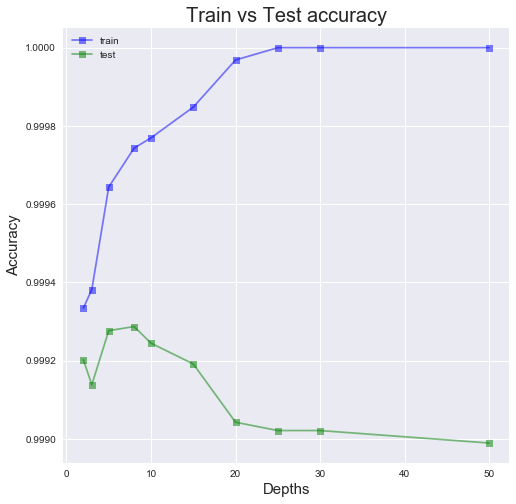

In [15]:
# Plot
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.plot(depths, train_accuracy, 's-', label = 'train', color = 'blue', alpha = 0.5)
ax.plot(depths, test_accuracy, 's-', label = 'test', color = 'green', alpha = 0.5)
ax.set_xlabel('Depths', size = 15)
ax.set_ylabel('Accuracy', size = 15)
ax.set_title('Train vs Test accuracy', size = 20)
ax.legend(loc = 'best')

We notice that as the depths of the decision trees go up, the train accuracy approaches 1 whereas the test accuracy fails significantly. This is a sign of overfitting so we choose to cross validate for the optimal depth. We redefine the tree depths.

In [16]:
depths = [2,3,4,5,6,7,8,9,10]
kf = KFold(n_splits = 3)
best_score = -float('inf')
best_depth = None
all_scores = []
for depth in depths:
    print(depth)
    dt = DecisionTree(max_depth = depth)
    val_scores = []
    for train_index, val_index in kf.split(X_train):
        X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
        dt.fit(X_train_cv, y_train_cv)
        val_scores.append(dt.score(X_val_cv, y_val_cv))
    cur_score = np.mean(val_scores)
    all_scores.append(cur_score)
    if cur_score > best_score:
        best_score = cur_score
        best_depth = depth

2
3
4
5
6
7
8
9
10


In [17]:
print('The best depth by cross validation is {}'.format(best_depth))

The best depth by cross validation is 7


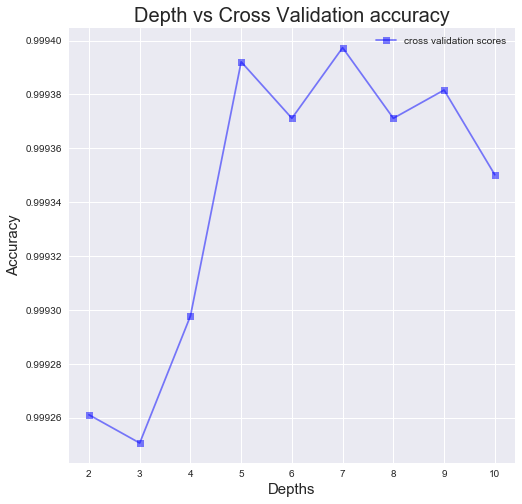

In [18]:
# Visualize how cross validaton reduce the issue of overfitting
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.plot(depths, all_scores, 's-',label = 'cross validation scores', color = 'blue', alpha = 0.5)
ax.set_xlabel('Depths', size = 15)
ax.set_ylabel('Accuracy', size = 15)
ax.set_title('Depth vs Cross Validation accuracy', size = 20)
ax.legend(loc = 'best')

In [19]:
# Fit the decision tree with the best depth and report the accuracy score
best_decision_tree = DecisionTree(max_depth = best_depth)
best_decision_tree.fit(X_train, y_train)
print('The best decision tree on Train : {}'.format(best_decision_tree.score(X_train, y_train)))
print('The best decision tree on Test : {}'.format(best_decision_tree.score(X_test, y_test)))

The best decision tree on Train : 0.9997170107955141
The best decision tree on Test : 0.9993190547628927


In [20]:
confusion_matrix(y_test, best_decision_tree.predict(X_test))

array([[93813,    12],
       [   52,   110]])

### 5. Random Forest
Random Forest, consists of simple decision trees, each with different set of predictors, makes predictions by voting for the label. We will use the tree depth from the previous question that prevents the issue of overfitting and can reduce the runtime of training the model. Random forest has number of parameters other than the tree depth that we can tune using cross validation：
 - number of predictors in each decision tree
 - number of trees in the model

After cross validation we have the following results:

$$\text{Random forest on the Train set accuracy} : 0.9997589351221046$$
$$\text{Random forest on the Test set accuracy} : 0.9994573717641801$$
$$\text{TPR} = \frac{124}{124 + 38} = 0.76543209876 $$

In [21]:
# Visualize the impact of number of trees on accuracy as the number of trees goes up
number_of_trees = [5,10,15,20,50,75,100]
train_scores = []
test_scores = []
for number_of_tree in number_of_trees:
    print(number_of_tree)
    rf = RandomForestClassifier(n_estimators = number_of_tree, max_depth = best_depth)
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))

5
10
15
20
50
75
100


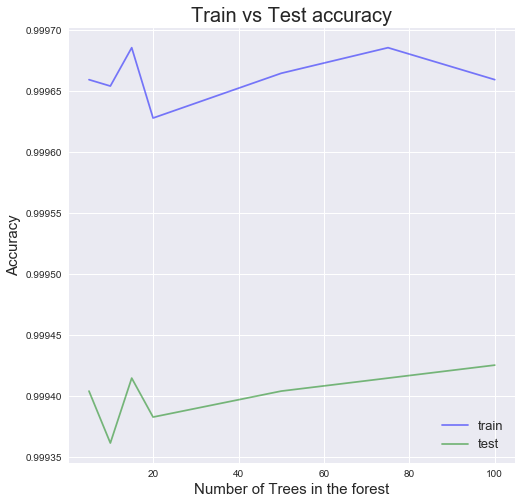

In [22]:
# Visualize the impact of number of trees in the random forest
# Plot
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.plot(number_of_trees, train_scores, label = 'train', color = 'blue', alpha = 0.5)
ax.plot(number_of_trees, test_scores, label = 'test', color = 'green', alpha = 0.5)
ax.set_xlabel('Number of Trees in the forest', size = 15)
ax.set_ylabel('Accuracy', size = 15)
ax.set_title('Train vs Test accuracy', size = 20)
ax.legend(loc = 'best', fontsize = 13)

We observe that the train and test acccuracy reach the highest around 20 number of trees and stabilize after we have enough number of trees.

In [24]:
# Visualize the impact of number of features
number_of_features = [i for i in range(2, 20)]
fixed_number_of_trees = 10
train_scores = []
test_scores = []
for number_of_feature in number_of_features:
    print(number_of_feature)
    rf = RandomForestClassifier(n_estimators = fixed_number_of_trees, max_depth = best_depth, max_features = number_of_feature)
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


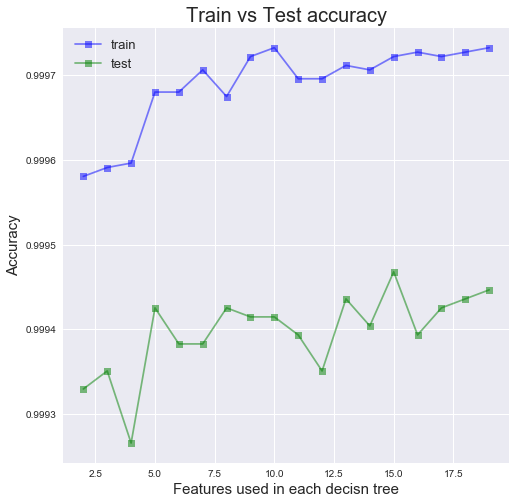

In [26]:
# Visualize the impact of number of features used in each decision tree
# Plot
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.plot(number_of_features, train_scores, 's-', label = 'train', color = 'blue', alpha = 0.5)
ax.plot(number_of_features, test_scores, 's-', label = 'test', color = 'green', alpha = 0.5)
ax.set_xlabel('Features used in each decisn tree', size = 15)
ax.set_ylabel('Accuracy', size = 15)
ax.set_title('Train vs Test accuracy', size = 20)
ax.legend(loc = 'best', fontsize = 13)

We observe that the lower the number of features in a single decision tree, the lower the test accuracy will be. But after the number of features increase to a certain number, the random forest will suffer from overfitting. Therefore, we decide to extend the idea of cross validation : cross validate on both the number of features and the number of trees at the same time to find the best combination.

In [29]:
# number of trees and number of features in cross validation
cross_num_trees = [5,15,20,25,35,40]
cross_num_features = [6,8,10,12,16,18,20]
cross_val_scores = []
kf = KFold(n_splits = 2)
best_num_tree = None
best_num_feature = None
best_score = -float('inf')
for num_tree in cross_num_trees:
    for num_feature in cross_num_features:
        print(num_tree, num_feature)
        val_scores = []
        for train_index, val_index in kf.split(X_train):
            X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
            rf = RandomForestClassifier(n_estimators = num_tree, max_depth = best_depth, max_features = num_feature)
            rf.fit(X_train_cv, y_train_cv)
            val_scores.append(rf.score(X_val_cv, y_val_cv))
        cur_score = np.mean(val_scores)
        if cur_score > best_score:
            best_num_tree = num_tree
            best_num_feature = num_feature
            best_score = cur_score

5 6
5 8
5 10
5 12
5 16
5 18
5 20
15 6
15 8
15 10
15 12
15 16
15 18
15 20
20 6
20 8
20 10
20 12
20 16
20 18
20 20
25 6
25 8
25 10
25 12
25 16
25 18
25 20
35 6
35 8
35 10
35 12
35 16
35 18
35 20
40 6
40 8
40 10
40 12
40 16
40 18
40 20


In [31]:
print('The best number of trees in the random forest: {}'.format(best_num_tree))
print('The best number of features in a single decision tree : {}'.format(best_num_feature))

The best number of trees in the random forest: 25
The best number of features in a single decision tree : 12


In [33]:
# Retrieve the best random forest model by cross validation
rf_best = RandomForestClassifier(n_estimators = best_num_tree, max_depth = best_depth, max_features = best_num_feature)
rf_best.fit(X_train, y_train)
print('Random forest on the Train set accuracy : {}'.format(rf_best.score(X_train, y_train)))
print('Random forest on the Test set accuracy : {}'.format(rf_best.score(X_test, y_test)))

Random forest on the Train set accuracy : 0.9997589351221046
Random forest on the Test set accuracy : 0.9994573717641801


In [34]:
confusion_matrix(y_test, rf_best.predict(X_test))

array([[93812,    13],
       [   38,   124]])

### 6. LDA
We also tried other model learning the boundary of the classification :
$$\text{LDA on train} : 0.9994235405093805$$
$$\text{LDA on test} : 0.9993403343015523$$
$$\text{TPR} = \frac{123}{123 + 39} = 0.75925925925$$

In [35]:
# Fit LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print('LDA on train : {}'.format(lda.score(X_train, y_train)))
print('LDA on test : {}'.format(lda.score(X_test, y_test)))

LDA on train : 0.9994235405093805
LDA on test : 0.9993403343015523


In [36]:
confusion_matrix(y_test, lda.predict(X_test))

array([[93802,    23],
       [   39,   123]])

### 7. QDA
$$\text{QDA on train} : 0.9762655906089508$$
$$\text{QDA on test} : 0.9761562769319161$$
$$\text{TPR} = \frac{136}{26 + 139} = 0.83950617284$$

In [37]:
# Fit QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
print('QDA on train : {}'.format(qda.score(X_train, y_train)))
print('QDA on test : {}'.format(qda.score(X_test, y_test)))

QDA on train : 0.9762655906089508
QDA on test : 0.9761562769319161


In [38]:
confusion_matrix(y_test, qda.predict(X_test))

array([[91610,  2215],
       [   26,   136]])

## Evaluation : Area Under the Curve (AUC) Performance Metric

In [30]:
def plot_roc(models, model_names, X_test, y_test):
    """ Function to plot the roc curves for the above models we fit in. Larger areas covered by the roc curves
        indicate better performance of the model, as ROC curve represents the trade-off between TPR and FPR with
        different threshold.
    """
    fig, ax = plt.subplot(1, 1, figsize = (10,10))
    for index, model in enumerate(models):
        # fpr, tpr, thresholds = metrics.roc_curve(y, scores)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
        ax.plot(fpr, tpr, label = 'ROC curve for ' + model_names[i], color = 'gold')
        ax.set_xlabel('False positive rate')
        ax.set_ylabel('True positive rate')
    ax.set_title('ROC curves')
    ax.legend(loc = 'best')

In [ ]:
models = [zero]